In [1]:
# -*- coding: utf-8 -*-
"""
Created on 2023/04/11
Revised on 2023/05/30

@author: mjofre - Marc Jofre
e-mail: marc.jofre@upc.edu
Technical University of Catalonia - Universitat Politècnica de Catalunya (UPC)
Network Engineering Department
"""
###########################################################################
# Seminar on Quantum Technologies for Communications and Computing: Networking and Systems
# Class
# Session 2 - Quantum implementation aspects
from IPython.display import display_html
display_html("<script>Jupyter.notebook.kernel.restart()</script>")
import os, sys, time
import numpy as np
import math
import matplotlib.pyplot as plt
from google.colab import files # This line can be commented when running in local computer
import matplotlib.style
import matplotlib as mpl
#print(plt.style.available)
mpl.style.use('default')

try:
  import qiskit
  import qiskit_aer
except:
  print("installing qiskit...")
  !pip install qiskit -U --quiet
  !pip install qiskit_aer -U --quiet
  print("installed qiskit.")
  import qiskit
  import qiskit_aer


installing qiskit...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 46.6 MB/s eta 0:00:00
installed qiskit.


# Measurement in the different basis

{'01': 526, '00': 498}


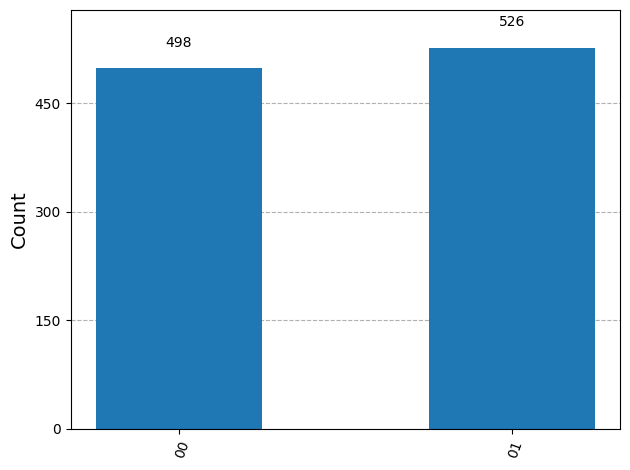

In [2]:
#########################################################
# Measurement of states and mixtures in different basis
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city
# https://arxiv.org/pdf/1804.03719.pdf: Quantum Algorithm Implementations for Beginners
NumberShots=1024

QubitMode='StateVector'#'StateVector'#'DensityMatrix'
MeasurementBasis='Z'#'Z': computational,'X': diagonal, 'Y': circular
UseBellState=False

qr=QuantumRegister(2,'q')
cr=ClassicalRegister(2,'c')
qc=QuantumCircuit(qr,cr)

if (QubitMode=='DensityMatrix'):
  if (UseBellState):
    RhoState = DensityMatrix([[0.25,0.0,0.0,0.25],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.25,0.0,0.0,0.25]]) # In the computational base. Bell state
  else:
    RhoState = DensityMatrix([[1.0/2.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,1.0/2.0]]) # In the computational base. Bipartite correlated state
  display(plot_state_city(RhoState,title='Initial'))
else:
  if (UseBellState):
    state = Statevector([1.0/np.sqrt(2),0.0,0.0,1.0/np.sqrt(2)]) # In the computational base. Bell state
  else:
    state = Statevector([1.0/np.sqrt(2),1.0/np.sqrt(2),0.0,0.0]) # In the computational base. Non Bell state

  qc.initialize(state.data, [0,1]) # Initialize both qubits at the same time

# https://quantumcomputing.stackexchange.com/questions/13605/how-to-measure-in-another-basis
if (MeasurementBasis=='X'): # diagonal
  # Measure both qubits and store the result in the classical bits
  qc.h(qr[0])
  qc.h(qr[1])
elif(MeasurementBasis=='Y'): # circular
  # Measure both qubits and store the result in the classical bits
  qc.sdg(qr[0])
  qc.h(qr[0])
  qc.sdg(qr[1])
  qc.h(qr[1])
else: #'Z' Computational
  qc.s(qr[0])
  qc.s(qr[1])
if (QubitMode=='DensityMatrix'):
  RhoStateEvolved=RhoState.evolve(qc)
else:
  qc.measure(qr,cr)

# Construct an ideal simulator
aersim = AerSimulator()

if (QubitMode=='DensityMatrix'):
  #print(RhoStateEvolved)
  display(plot_state_city(RhoStateEvolved,title='Evolved'))
  #print(np.sum(RhoStateEvolved.data,axis=0))
  StatesProb=np.sum(np.real(RhoStateEvolved.data),axis=0)
  counts={'00':NumberShots*StatesProb[0],'01':NumberShots*StatesProb[1],'10':NumberShots*StatesProb[2],'11':NumberShots*StatesProb[3]}
  display(plot_histogram(counts))
else:
  result=aersim.run(qc,shots=NumberShots).result()
  counts=result.get_counts(qc)
  print(counts)
  display(plot_histogram(counts))


# Entanglement

|00> state entanglement: 0.00


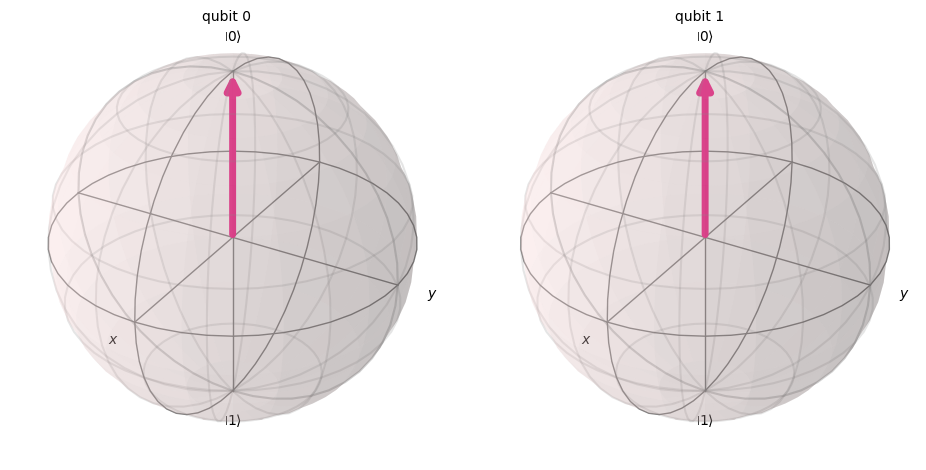

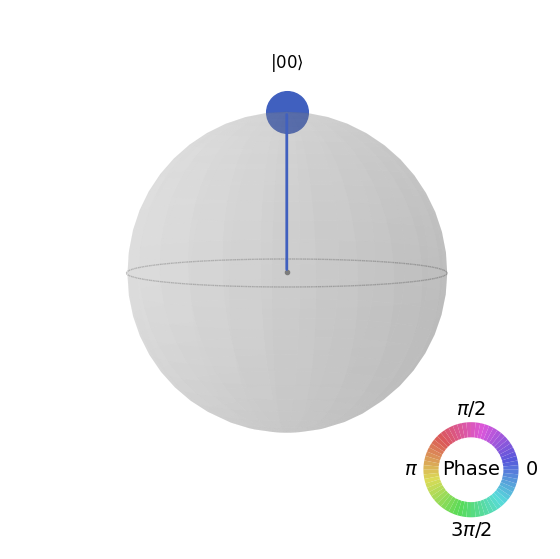

In [3]:
######################################################################
# Check the amount of entanglement
from qiskit.quantum_info import entanglement_of_formation
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere
import numpy as np
li = np.sqrt(0.5) #shortcut for 1/sqrt(2)

#|00> state:
just00 = [1, 0, 0, 0]
print(f'|00> state entanglement: {entanglement_of_formation(just00):.2f}')
display(plot_bloch_multivector(just00))
#returns 0.0
display(plot_state_qsphere(just00))

Bell state entanglement: 1.00


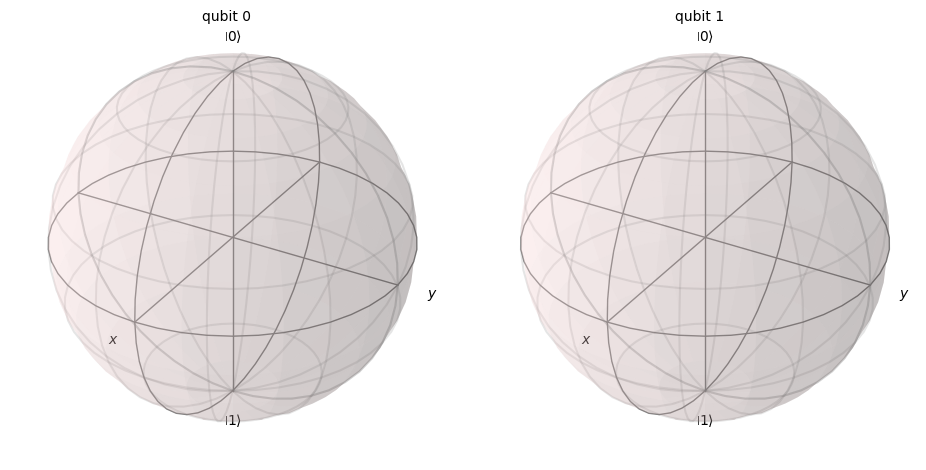

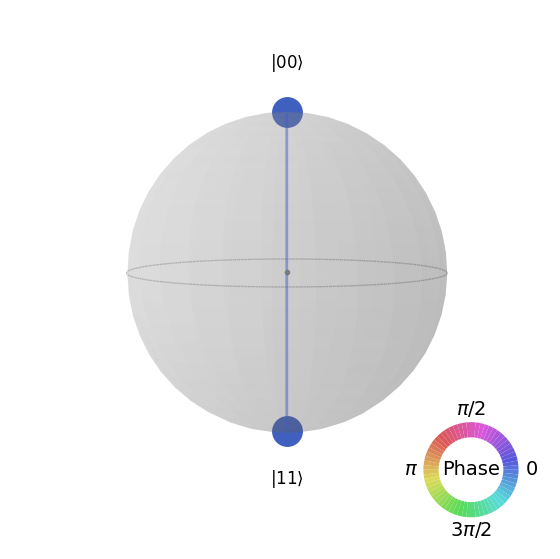

In [4]:
#Bell state:
bell = [li, 0, 0, li]
print(f'Bell state entanglement: {entanglement_of_formation(bell):.2f}')
display(plot_bloch_multivector(bell))
#returns 0.9999999999999999 (practically 1...)
display(plot_state_qsphere(bell))

|+0> state entanglement: 1.60e-16


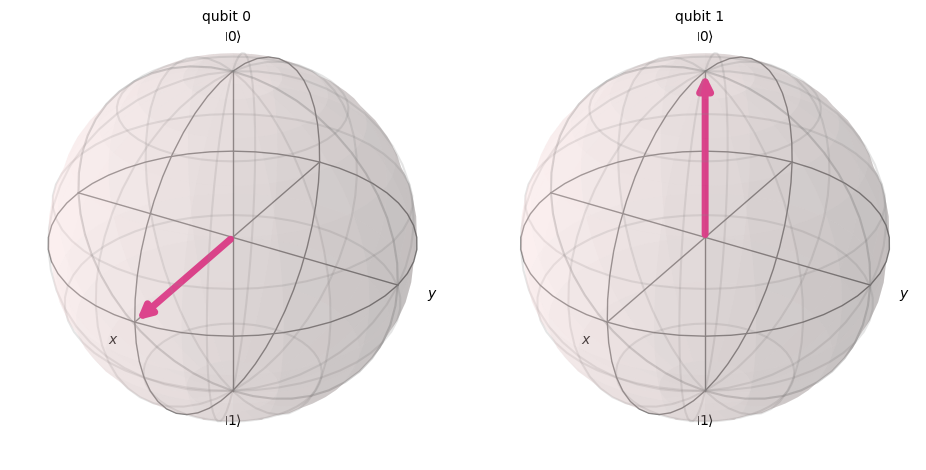

Notice that Qiskit qubit ordering is little-endian, the opposite to class theory.


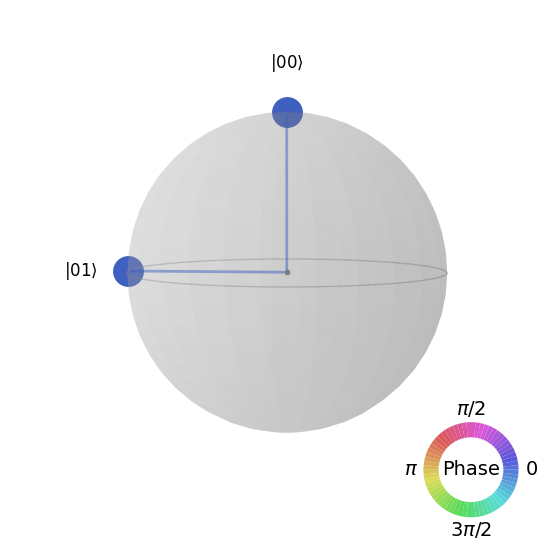

In [5]:
#Not really Bell (|+0>):
plus0 = [li, li, 0, 0]
print(f'|+0> state entanglement: {entanglement_of_formation(plus0):.2e}')
display(plot_bloch_multivector(plus0))
#returns 1.6017132519074586e-16 (practically zero...)
print('Notice that Qiskit qubit ordering is little-endian, the opposite to class theory.')
display(plot_state_qsphere(plus0))

State vector: [0.38496748-0.0918411j  0.03832467+0.03038352j 0.0390152 +0.02693084j
 0.21717116+0.08700736j]
{'01': 253, '10': 246, '00': 793, '11': 756}


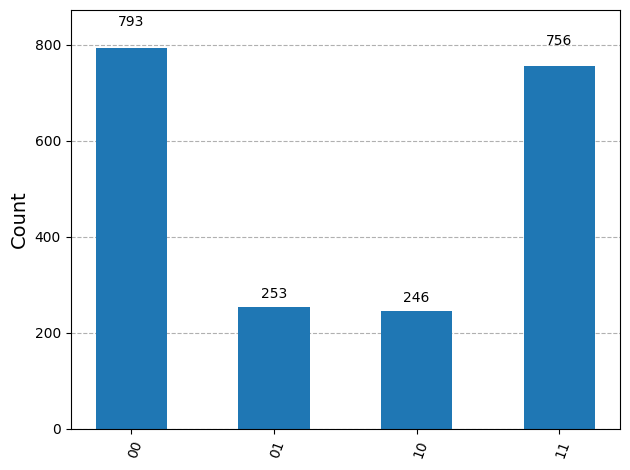

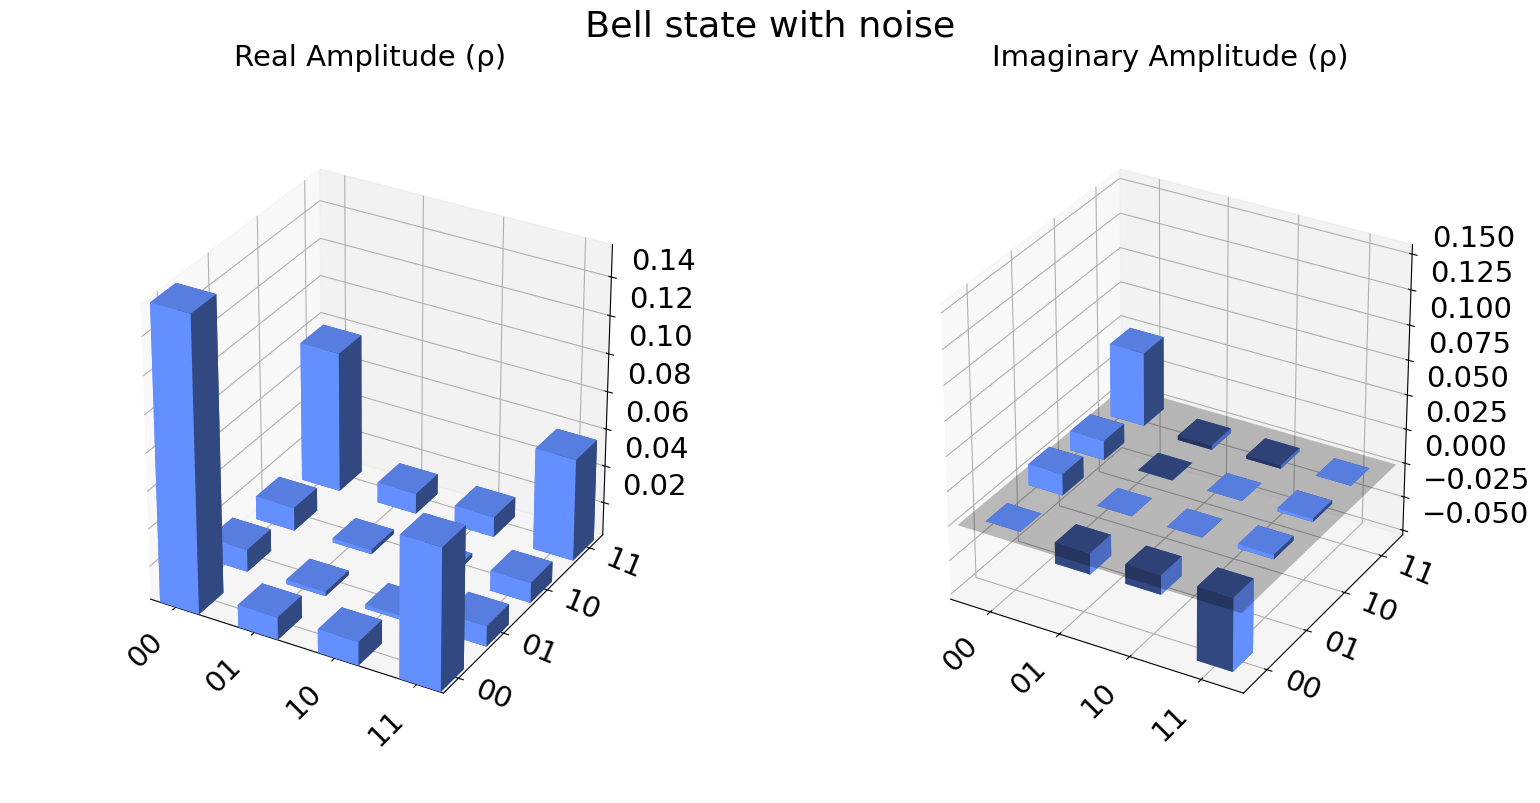

In [6]:
######################################################################
# Entanglement circuit with or without noise
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit_aer.noise as noise
NoiseFlag=True # Activate or desactivate noise
NumberShots=int(2048)

# Create a quantum circuit with 2 qubits and 2 clasical bits
qr=QuantumRegister(2,'q')
cr=ClassicalRegister(2,'c')
qc1=QuantumCircuit(qr,cr)

# Apply a Hadamard gate to the first qubit
qc1.h(qr[0])

# Apply a CNOT gate between the first and second qubits
qc1.cx(qr[0],qr[1])
#print(qc1)
qc1.save_statevector(label='v1', pershot = True)
# Measure both qubits and store the result in the classical bits
qc1.measure(qr,cr)

# Error probabilities
prob_1 = 0.5  # 1-qubit gate
prob_2 = 0.5   # 2-qubit gate
# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['h','rz', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
#print(noise_model)

# Run the circuit on a simulator
sv1aux = np.zeros((4),dtype=np.complex64)
if (NoiseFlag):
  backend = QasmSimulator(method='statevector',noise_model=noise_model)
  circ = transpile(qc1, backend)
  result=backend.run(circ,noise_model=noise_model,shots=NumberShots).result()
  for iIterStateVector in range(0,NumberShots,1):
    sv1aux += np.asarray([result.data(0)['v1'][iIterStateVector][0],result.data(0)['v1'][iIterStateVector][1],result.data(0)['v1'][iIterStateVector][2],result.data(0)['v1'][iIterStateVector][3]]) # state vector
  sv1=sv1aux/float(NumberShots)
else:
  # Construct an ideal simulator
  aersim = AerSimulator()
  result=aersim.run(qc1,shots=NumberShots).result()
  sv1 = [result.data(0)['v1'][0][0],result.data(0)['v1'][0][1],result.data(0)['v1'][0][2],result.data(0)['v1'][0][3]] # state vector#sv1=result.data(0)['v1']

print(f'State vector: {sv1}')

# Print the results
counts=result.get_counts(qc1)
print(counts)
display(plot_histogram(counts))

if (NoiseFlag):
  plotstring='Bell state with noise'
else:
  plotstring='Bell state'
display(plot_state_city(sv1, title=plotstring))

In [7]:
###########################################################################
# Fidelity of a system with noise and errors
# set up qc1 and qc2
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
import qiskit_aer.noise as noise
from qiskit.quantum_info import state_fidelity
NumberShots=int(2048)
NoiseFlag=True # Activate or desactivate noise

# Create a quantum circuit with 2 qubits and 2 clasical bits
qr=QuantumRegister(2,'q')
cr=ClassicalRegister(2,'c')
qc1=QuantumCircuit(qr,cr)

# Apply a Hadamard gate to the first qubit
qc1.h(qr[0])
# Apply a CNOT gate between the first and second qubits
qc1.cx(qr[0],qr[1])
qc1.save_statevector(label='v1', pershot = True)
## Measure both qubits and store the result in the classical bits
#qc1.measure(qr,cr)

# Create the expected statevector
q2 = QuantumRegister(2)
bell = QuantumCircuit(q2)
bell.h(q2[0])
bell.cx(q2[0], q2[1])
bell.save_statevector(label='v1', pershot = True)
#print(bell)

# Error probabilities
prob_1 = 0.1  # 1-qubit gate
prob_2 = 0.1   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['h','rz', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
#print(noise_model)

backend1 = QasmSimulator(method='statevector',noise_model=noise_model)
backend2 = QasmSimulator(method='statevector')

circ = transpile(bell, backend2)
sv2 = (backend2.run(circ,shots=NumberShots).result()).data(0)['v1'][0]

AvgStateFidelity=0.0
if (NoiseFlag):
  circ = transpile(qc1, backend1)
  result=backend1.run(circ,noise_model=noise_model,shots=NumberShots).result()
  for iIter in range(0,NumberShots,1):
    sv1 = result.data(0)['v1'][iIter]
    AvgStateFidelity+=state_fidelity(sv1, sv2)
  AvgStateFidelity=AvgStateFidelity/float(NumberShots)
else:
  circ = transpile(qc1, backend2)
  result=backend2.run(qc1,shots=NumberShots).result()
  sv1 = result.data(0)['v1'][0]
  AvgStateFidelity=state_fidelity(sv1, sv2)

print(f'Average fidelity: {AvgStateFidelity:.2f}')

Average fidelity: 0.88


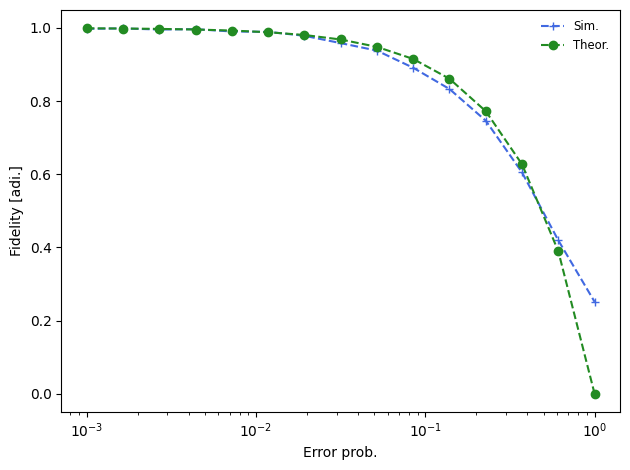

In [8]:
###########################################################################
# Fidelity dependence with error probability
# set up qc1 and qc2
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit import QuantumCircuit, QuantumRegister
import qiskit_aer.noise as noise
from qiskit.quantum_info import state_fidelity
NumberShots=int(2048)
NoiseFlag=True # Activate or desactivate noise

qr=QuantumRegister(2,'q')
qc1=QuantumCircuit(qr)
# Apply a Hadamard gate to the first qubit
qc1.h(qr[0])
# Apply a CNOT gate between the first and second qubits
qc1.cx(qr[0],qr[1])
qc1.save_statevector(label='v1', pershot = True)

# Create the expected statevector
q2 = QuantumRegister(2)
bell = QuantumCircuit(q2)
bell.h(q2[0])
bell.cx(q2[0], q2[1])
bell.save_statevector(label='v1', pershot = True)
#print(bell)

backend1 = QasmSimulator(method='statevector',noise_model=noise_model)
backend2 = QasmSimulator(method='statevector')

circ = transpile(bell, backend2)
sv2 = (backend2.run(circ,shots=NumberShots).result()).data(0)['v1'][0]

NcalcErrorProb=15
ErrorProbScan=np.logspace(-3,0,NcalcErrorProb)
AvgStateFidelityScan=np.zeros((NcalcErrorProb),dtype=np.float32)
TheorStateFidelityScan=np.zeros((NcalcErrorProb),dtype=np.float32)
for iIterScan in range(0,NcalcErrorProb,1):
  # Error probabilities
  prob_1 = ErrorProbScan[iIterScan]  # 1-qubit gate
  prob_2 = ErrorProbScan[iIterScan]  # 2-qubit gate

  # Depolarizing quantum errors
  error_1 = noise.depolarizing_error(prob_1, 1)
  error_2 = noise.depolarizing_error(prob_2, 2)

  # Add errors to noise model
  noise_model = noise.NoiseModel()
  noise_model.add_all_qubit_quantum_error(error_1, ['h','rz', 'sx', 'x'])
  noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
  #print(noise_model)

  if (NoiseFlag):
    circ = transpile(qc1, backend1)
    result=backend1.run(circ,noise_model=noise_model,shots=NumberShots).result()
    for iIter in range(0,NumberShots,1):
      sv1 = result.data(0)['v1'][iIter]
      AvgStateFidelityScan[iIterScan]+=state_fidelity(sv1, sv2)
    AvgStateFidelityScan[iIterScan]=AvgStateFidelityScan[iIterScan]/float(NumberShots)
  else:
    circ = transpile(qc1, backend2)
    result=backend2.run(qc1,shots=NumberShots).result()
    sv1 = result.data(0)['v1'][0]
    AvgStateFidelityScan[iIterScan]=state_fidelity(sv1, sv2)

  TheorStateFidelityScan[iIterScan]=(1.0-ErrorProbScan[iIterScan])

plt.figure()
line1,=plt.plot(ErrorProbScan,AvgStateFidelityScan,'royalblue',linestyle='dashed',marker='+')
line2,=plt.plot(ErrorProbScan,TheorStateFidelityScan,'forestgreen',linestyle='dashed',marker='o')
#plt.xlim(np.max([Time1[0],Time2[0]]),np.min([Time1[-1],Time2[-1]]))
plt.xlabel('Error prob.',color='k')
plt.ylabel('Fidelity [adi.]',color='k')
plt.xscale('log')
plt.legend((line1,line2), ('Sim.','Theor.'),loc="best",shadow = False, fancybox = False, frameon = False, fontsize='small')# 'best'
plt.tight_layout()
plt.show()

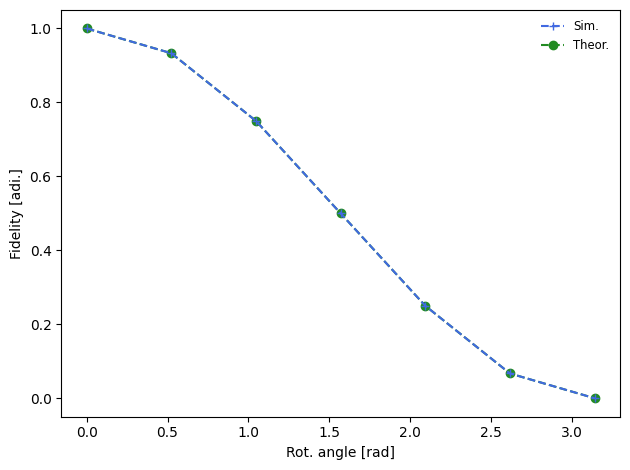

In [9]:
###########################################################################
# Fidelity of a superpositon qubit through a polarization beam splitter with rotating angle
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit import QuantumCircuit, QuantumRegister
import qiskit_aer.noise as noise
from qiskit.quantum_info import state_fidelity, Statevector
NumberShots=int(2048)

# Create initial superposition state vector
state = Statevector([1.0/np.sqrt(2),1.0/np.sqrt(2)]) # In the computational base. Non Bell state

RotAngleMax=np.pi
NcalcRotAngleScan=7
RotAngleMax=np.pi
RotAngleScan=np.linspace(0,RotAngleMax,NcalcRotAngleScan)
AvgStateFidelity=np.zeros((NcalcRotAngleScan),dtype=np.float32)
TheorStateFidelityScan=np.zeros_like(AvgStateFidelity)
backend = QasmSimulator(method='statevector')
for iIter in range(0,NcalcRotAngleScan,1):
  qr=QuantumRegister(1,'q')
  qc1=QuantumCircuit(qr)

  qc1.initialize(state.data, [0]) # Initialize qubit
  qc1.save_statevector(label='v1', pershot = True) # Reference state vector

  ## Go through polarization beam splitter
  RotTheta=RotAngleScan[iIter]#0.0*np.pi/4
  qc1.rz(RotTheta,0)
  qc1.save_statevector(label='v2', pershot = True) # Reference state vector

  circ = transpile(qc1, backend)
  result=backend.run(qc1,shots=NumberShots).result()
  sv1 = result.data(0)['v1'][0]
  sv2 = result.data(0)['v2'][0]
  AvgStateFidelity[iIter]=state_fidelity(sv1, sv2)
  TheorStateFidelityScan[iIter]=1.0-np.sin(0.5*RotAngleScan[iIter])**2

#print(f'Average fidelity: {AvgStateFidelity:.2f}')
plt.figure()
line2,=plt.plot(RotAngleScan,TheorStateFidelityScan,'forestgreen',linestyle='dashed',marker='o')
line1,=plt.plot(RotAngleScan,AvgStateFidelity,'royalblue',linestyle='dashed',marker='+')
#plt.xlim(np.max([Time1[0],Time2[0]]),np.min([Time1[-1],Time2[-1]]))
plt.xlabel('Rot. angle [rad]',color='k')
plt.ylabel('Fidelity [adi.]',color='k')
#plt.xscale('log')
plt.legend((line1,line2), ('Sim.','Theor.'),loc="best",shadow = False, fancybox = False, frameon = False, fontsize='small')# 'best'
plt.tight_layout()
plt.show()


# Wrap-up of Probability errors and Fidelity

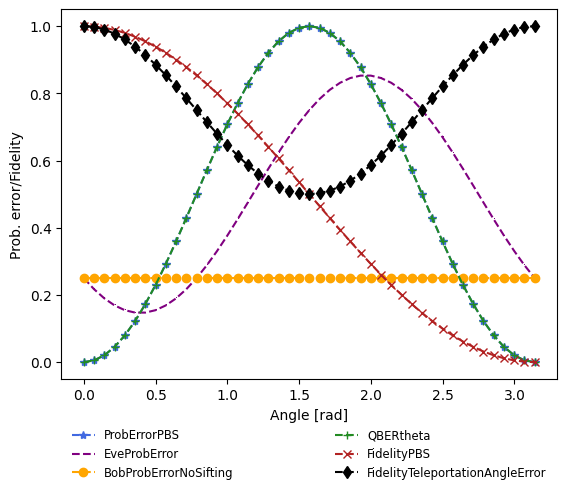

In [10]:
##############################################################################
# Relation of Probability errors, QBER, Fidelities with the the rotation of the measurement basis \theta
NcalcAngle=45
MaxAngle=np.pi
AnglesScan=np.linspace(0,MaxAngle,NcalcAngle)

ProbErrorPBS=1.0-np.cos(AnglesScan)**2
EveProbError=0.25*((1.0-np.cos(2.0*AnglesScan))+(1.0-np.sin(2.0*AnglesScan))) # Error probability when Eve is randomly changing basis (it is minimized to 14.64% when theta=np.pi/8 - Breidbart basis)
BobProbErrorNoSifting=0.25*((1.0-np.cos(2.0*AnglesScan)**2)+(1.0-np.sin(2.0*AnglesScan)**2)) # Error probability when Bob is randomly changes basis (before key sifting)
QBERtheta=1.0-np.cos(AnglesScan)**2 # Error probability equivalent to Bob when doing sifting
FidelityPBS=1.0-np.sin(AnglesScan/2.0)**2# Angle is half, because at np.pi/2.0 its like at half place between the two states
FidelityTeleportationAngleError=1.0-ProbErrorPBS/2.0
# Fidelity towards a Bell state if usually as F=0.5*(1+cos(\theta)); depending on the Bell state of interest \theta has to be adjusted or even the cos can be replaced by a sin
# Fidelity cascaded devices F=Fi**N
# Fidelity in terms of coincidences F=RatioRc/(1.0+RatioRc), where RatioRc is the ratio of coincidences between RcParallel/RcOrthogonal (Rc coincidence rate)

plt.figure()
line1,=plt.plot(AnglesScan,ProbErrorPBS,'royalblue',linestyle='dashed',marker='*')
line2,=plt.plot(AnglesScan,EveProbError,'purple',linestyle='dashed',marker=',')
line3,=plt.plot(AnglesScan,BobProbErrorNoSifting,'orange',linestyle='dashed',marker='o')
line4,=plt.plot(AnglesScan,QBERtheta,'forestgreen',linestyle='dashed',marker='+')
line5,=plt.plot(AnglesScan,FidelityPBS,'firebrick',linestyle='dashed',marker='x')
line6,=plt.plot(AnglesScan,FidelityTeleportationAngleError,'black',linestyle='dashed',marker='d')
plt.legend((line1, line2, line3, line4, line5, line6), ('ProbErrorPBS','EveProbError','BobProbErrorNoSifting','QBERtheta','FidelityPBS','FidelityTeleportationAngleError'),bbox_to_anchor=(0, -0.3, 1, 0), loc="lower left", mode="expand", ncol=2,shadow = False, fancybox = False, frameon = False, fontsize='small')# 'best'
plt.xlabel('Angle [rad]',color='k')
plt.ylabel('Prob. error/Fidelity',color='k')
plt.show()

####################################################
# Relevant transmittivity/loss related equations:
# Rr=eta Rs # where eta is the transmissivity as eta \leq 1 and proportional to np.exp(-att Distance), where att is the attenuation att\geq 0.
# dBatt=dBLoss/Km*L(Km)
# dBatt=-10 log10(eta)
# ProbabilityPhotonLoss=1-eta=1-np.exp(-Distance/L0), where dBLoss/Km * L0=-10 log10(1/e)

####################################################
# Relevant trigonometric relations
# cos(theta)**2+sin(theta)**2=1
# sin(theta)**2=0.5*(1-cos(2theta))
# cos(theta)**2=0.5*(1+cos(2theta))